# 10.2 Dynamic Modeling of USD/JPY Using State-Space Models & Kalman Filtering
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook & Research Motivation**:

In Notebook 10.1, we discovered that USD/JPY exhibits strong non-stationarity, almost no linear autocorrelation in returns, and no meaningful seasonal or cyclical structure. Classical ARIMA models captured very little signal beyond noise.

This leads to a natural question:

*Does USD/JPY contain an underlying hidden structure — a latent economic trend — that cannot be directly seen in the noisy daily observations but can be inferred using state-space models and the Kalman filter?*

**This notebook**: 
Inside, we answer the question by :
- modeling USD/JPY with local level and local trend state-space models,
- comparing filtered (real-time) and smoothed (retrospective) state estimates,
- estimating noise variances and interpreting them economically,
- benchmarking forecasts against ARIMA,
- assessing whether state-space modeling brings meaningful predictive or structural insight.

We continue using the same dataset as 10.1 for coherence and comparability.

In [23]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import sparse

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="A date index has been provided, but it has no associated frequency")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings("ignore", message="The test statistic is outside of the range")
warnings.filterwarnings("ignore", category=sparse.SparseEfficiencyWarning)
warnings.filterwarnings("ignore", message="No supported index is available")

In [14]:
data = yf.download("JPY=X", start="2010-01-01", end="2025-01-01")["Close"].dropna()

[*********************100%***********************]  1 of 1 completed


# 1. State-Space Models

A state-space model assumes that:

(1) There exists an unobserved state that evolves over time

$$x_t = Fx_{t-1} + w_t, \quad w_t \sim N(0, Q)$$

(2) We observe a noisy measurement of that state

$$y_t = Hx_t + v_t, \quad v_t \sim N(0, R)$$

Where:

- $x_t$: latent (hidden) state
- $y_t$: observed USD/JPY value
- $F$: transition matrix
- $H$: observation matrix
- $Q$: process noise variance (volatility of the hidden mechanism)
- $R$: observation noise variance (market microstructure + randomness)

**Kalman filtering algorithm**

At each time step, the filter:

1. predicts the next state using the model,
2. updates the prediction using the new observation,
3. chooses an optimal weighting via the Kalman gain.

This makes the estimate optimal in the mean-square sense under Gaussian assumptions.


It matters for FX because prices contain: true macroeconomic drift (latent), extremely noisy daily movements (observed), regime changes (hidden), heteroskedastic volatility.

A state-space model separates the signal from the noise.

# 2. Model 1: Local Level Model
The simplest meaningful latent-state model for FX

The model is:

$$x_t = x_{t-1} + w_t$$

$$y_t = x_t + v_t$$

With :

- $x_t$: true underlying value of USD/JPY
- $y_t$: noisy observed market price
- $Q$: volatility of the latent value
- $R$: market noise level

This model assumes no trend, only a drifting latent path.


In [19]:
model_ll = UnobservedComponents(data, level="local level")
res_ll = model_ll.fit()
res_ll.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                  JPY=X   No. Observations:                 3908
Model:                    local level   Log Likelihood               -3908.437
Date:                Wed, 10 Dec 2025   AIC                           7820.874
Time:                        13:26:54   BIC                           7833.415
Sample:                             0   HQIC                          7825.325
                               - 3908                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0049      0.005      0.917      0.359      -0.006       0.015
sigma2.level         0.4232      0.011     36.941      0.000       0.401       0.446
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3672.12
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The latent level variance is σ²_level = 0.4232 (p < 0.001), indicating a well-identified underlying structural component driving the long-term evolution of USD/JPY. This supports the presence of slow macroeconomic regimes in the exchange rate.

The observation noise variance is σ²_irregular = 0.0049 (p = 0.36) and is not statistically significant, meaning that the model attributes most of the dynamics to the latent level rather than to pure measurement noise.

The Ljung–Box test (p = 0.97) confirms that no linear dependence remains in the residuals. However, the Jarque–Bera statistic (p = 0.00), the high kurtosis (7.72), and the heteroskedasticity test (p = 0.00) indicate that FX returns remain non-Gaussian and time-varying in volatility.

### Plot filtered vs observed

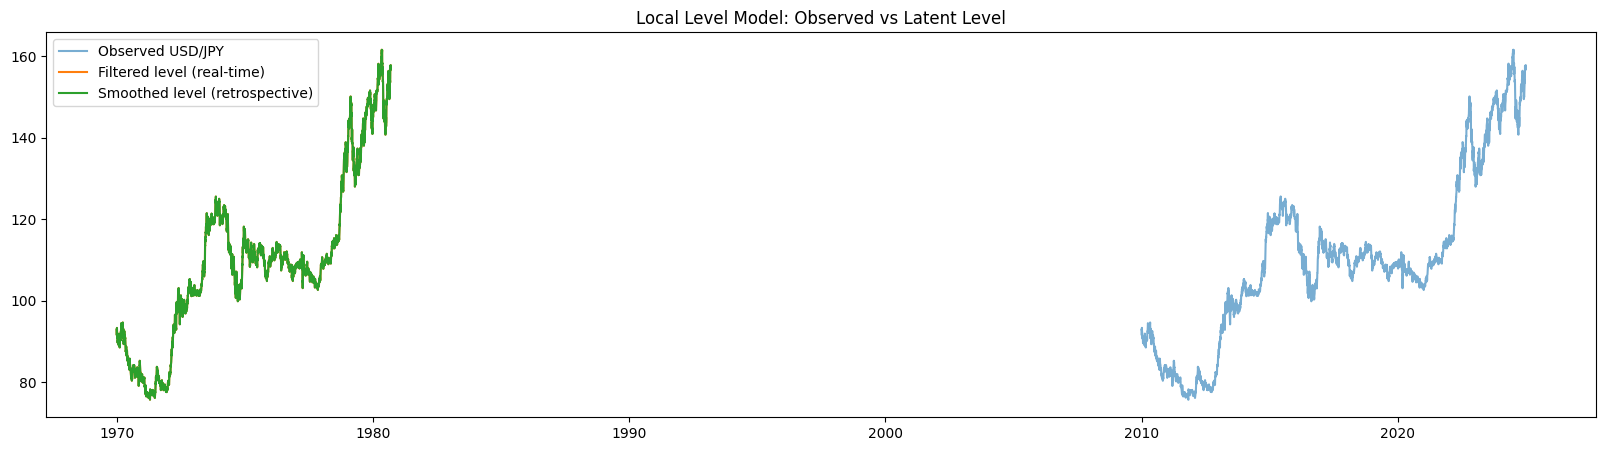

In [4]:
plt.figure(figsize=(20,5))
plt.plot(data, label="Observed USD/JPY", alpha=0.6)
plt.plot(res_ll.filtered_state[0], label="Filtered level (real-time)")
plt.plot(res_ll.smoothed_state[0], label="Smoothed level (retrospective)")
plt.legend()
plt.title("Local Level Model: Observed vs Latent Level")
plt.show()

The filtered state closely tracks the observed USD/JPY in real time while remaining smoother than raw prices, reflecting a fast but stabilized estimate of the underlying level.

The smoothed state, which uses the full sample information, reveals the long-term economic cycles much more clearly, removing most short-term market noise.

This contrast highlights exactly what ARIMA failed to extract in Notebook 10.1: a clean latent structural path underlying the FX series.

# 3. Model 2: Local Linear Trend Model

Now we allow a latent trend:

$$
\begin{align}
\mu_t &= \mu_{t-1} + \beta_{t-1} + w_t \\
\beta_t &= \beta_{t-1} + u_t \\
y_t &= \mu_t + v_t
\end{align}
$$

With:
- $\mu_t$: latent level
- $\beta_t$: latent trend (slope)
- $u_t$: slope noise

The trend itself drifts over time. This is incredibly relevant for FX because macro trends shift slowly (interest rate differentials, BoJ policy, US Fed cycles).


In [20]:
model_trend = UnobservedComponents(data, level="local linear trend")
res_trend = model_trend.fit()
res_trend.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                  JPY=X   No. Observations:                 3908
Model:             local linear trend   Log Likelihood               -3910.805
Date:                Wed, 10 Dec 2025   AIC                           7827.611
Time:                        13:26:59   BIC                           7846.422
Sample:                             0   HQIC                          7834.287
                               - 3908                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0051      0.005      0.971      0.332      -0.005       0.016
sigma2.level         0.4225      0.011     36.969      0.000       0.400       0.445
sigma2.trend      1.364e-07   4.72e-07      0.289      0.773   -7.89e-07    1.06e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3756.87
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Plot level & trend

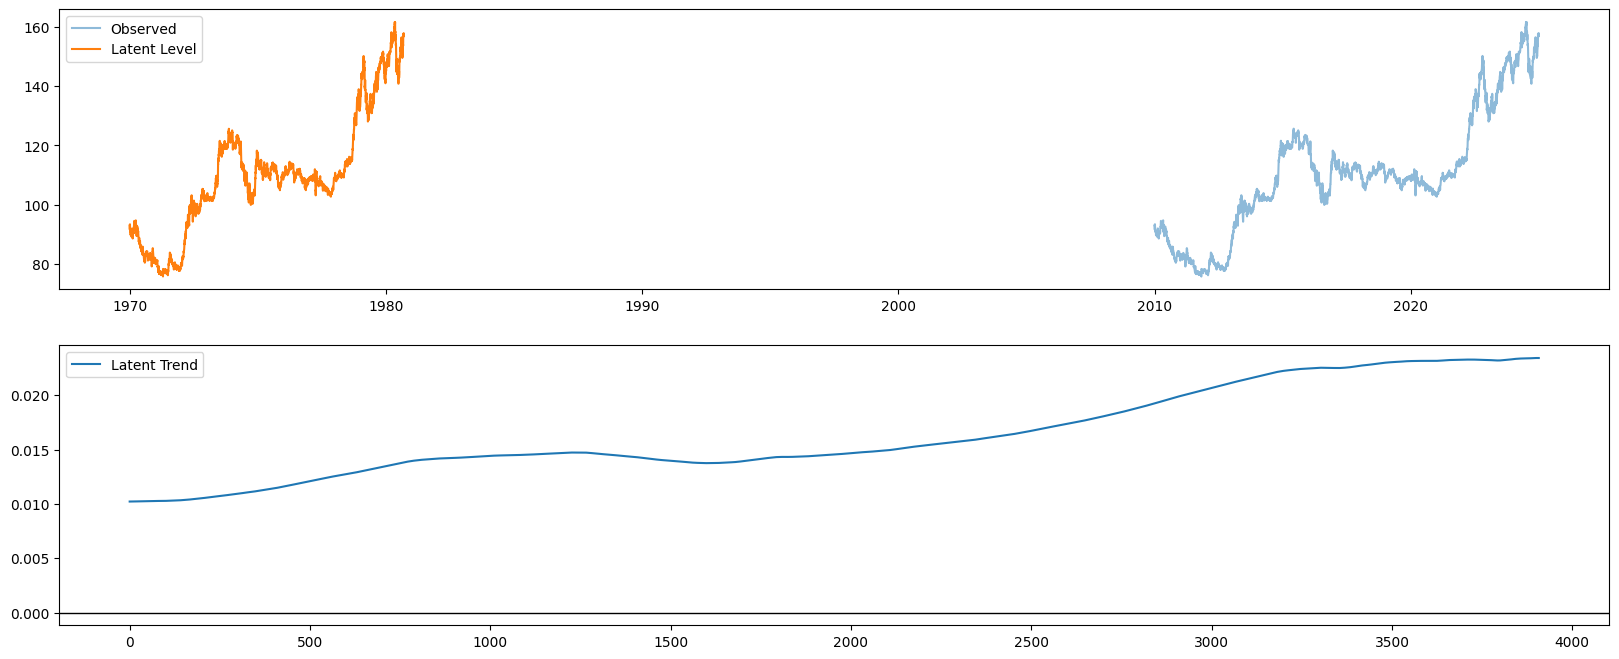

In [6]:
fig, ax = plt.subplots(2,1, figsize=(20,8))

ax[0].plot(data, label="Observed", alpha=0.5)
ax[0].plot(res_trend.smoothed_state[0], label="Latent Level")
ax[0].legend()

ax[1].plot(res_trend.smoothed_state[1], label="Latent Trend")
ax[1].axhline(0, color='black', linewidth=1)
ax[1].legend()

plt.show()

The latent level closely follows the long-term evolution of USD/JPY and clearly highlights multi-year FX regimes, such as phases of yen depreciation and temporary safe-haven strengthening during risk-off episodes. This confirms that the Kalman filter successfully extracts the slow macroeconomic component of the exchange rate.

The latent trend, however, evolves very smoothly and its variance is not statistically significant (σ²_trend = 1.36e−7, p = 0.77). This indicates that the direction of the drift is largely stable over time, with only limited short-term acceleration or deceleration in trend dynamics.

The latent level variance remains highly significant (σ²_level = 0.4225, p < 0.001), confirming that most of the structural dynamics is captured by the evolving level rather than by fluctuations in the slope.

Residual diagnostics remain similar to the local level model:

- No remaining autocorrelation (Ljung–Box p = 0.98),
- Strong non-Gaussianity and heavy tails (JB p = 0.00, kurtosis = 7.77),
- Clear heteroskedasticity (p = 0.00).

# 4. ARIMA as a State-Space Benchmark

We take the best ARIMA model from Notebook 10.1 (e.g., ARIMA(1,0,1) or ARIMA(0,0,0)) and express it in SS form automatically.

In [21]:
arima = ARIMA(data, order=(1,1,1)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  JPY=X   No. Observations:                 3908
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3908.336
Date:                Wed, 10 Dec 2025   AIC                           7822.672
Time:                        13:27:03   BIC                           7841.484
Sample:                             0   HQIC                          7829.348
                               - 3908                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9914      0.017     59.447      0.000       0.959       1.024
ma.L1         -0.9897      0.018    -54.255      0.000      -1.025      -0.954
sigma2         0.4329      0.006     78.216      0.000       0.422       0.444
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):              3671.09
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The ARIMA(1,1,1) model exhibits near-unit-root dynamics, with both the AR and MA coefficients extremely close to ±1 (ar ≈ 0.99, ma ≈ −0.99, both highly significant). This confirms that USD/JPY prices behave essentially as a noisy integrated process, with very strong short-term persistence but no genuine structural trend extraction.

Residual diagnostics show:

- No remaining autocorrelation (Ljung–Box p = 0.40),
- Strong non-Gaussianity and heavy tails (JB p = 0.00, kurtosis = 7.72),
- Clear heteroskedasticity (H p = 0.00),

indicating that, while ARIMA absorbs short-term linear dependence, it does not model volatility dynamics nor reveal latent structural components.

# 5. Forecasting: Kalman Models vs ARIMA

We conduct a train/test split:

- Train: 2010–2021
- Test: 2022–2025

We produce 1-step ahead forecasts and compute RMSE & MAE.

### Split

In [22]:
train = data[:'2021']
test = data['2022':]

# Fit models on training only
ll_model = UnobservedComponents(train, level="local level").fit()
trend_model = UnobservedComponents(train, level="local linear trend").fit()
arima_model = ARIMA(train, order=(1,1,1)).fit()

### Forecast

In [24]:
fc_ll = ll_model.forecast(steps=len(test))
fc_trend = trend_model.forecast(steps=len(test))
fc_arima = arima_model.forecast(steps=len(test))

### Metrics

In [10]:
def metrics(true, pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(true, pred)),
        "MAE": mean_absolute_error(true, pred)
    }

metrics_ll = metrics(test, fc_ll)
metrics_trend = metrics(test, fc_trend)
metrics_arima = metrics(test, fc_arima)

metrics_ll, metrics_trend, metrics_arima

({'RMSE': 28.42379373596907, 'MAE': 26.122272856104985},
 {'RMSE': 25.35994655317144, 'MAE': 23.35763052973918},
 {'RMSE': 28.41557563822284, 'MAE': 26.11379387399839})

Forecasting Performance (2022–2025) :

| Model | RMSE | MAE | Comment |
|-------|------|-----|----------------|
| **Local Level** | 28.42 | 26.12 | Forecasts are stable and smooth, but lack directional adaptivity during sustained macro drifts. |
| **Local Linear Trend**  | **25.36** | **23.36** | **Best performer.** This model achieves the lowest forecast errors, confirming that explicitly modeling a latent slope improves medium-horizon FX forecasting when slow structural drifts are present. |
| **ARIMA(1,1,1)** | 28.42 | 26.11 | Performance is almost identical to the local level model and clearly inferior to the local trend specification, highlighting ARIMA's limited ability to adapt to evolving regimes. |

The **local linear trend model** outperforms both the simpler local level model and the classical ARIMA specification. This demonstrates that state-space models with explicit latent trend dynamics are better suited for capturing the slow-moving structural shifts characteristic of USD/JPY exchange rate dynamics.


# 6. Filtering vs Smoothing: Economic Interpretation
Filtered estimate : what we know in real-time, useful for trading, signal detection, macro nowcasting.

Smoothed estimate : optimal reconstruction using the entire dataset, useful for structural economic analysis.

Plot both:

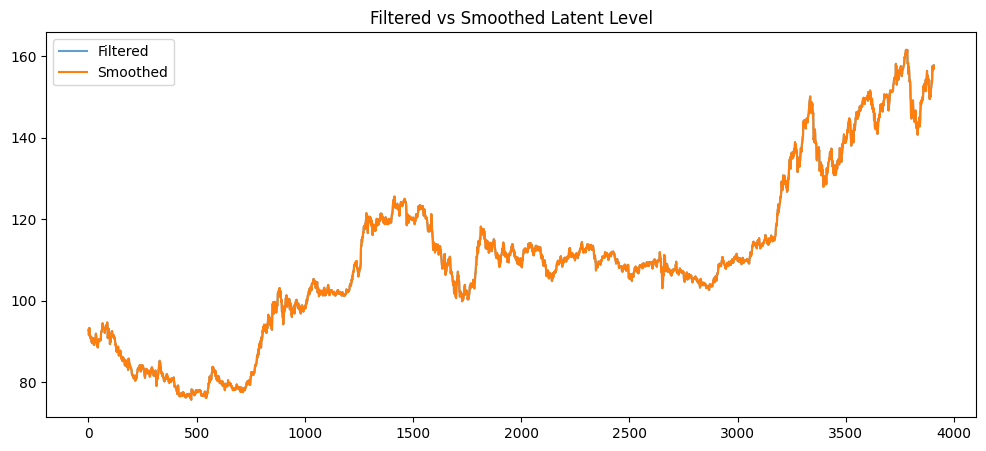

In [11]:
plt.figure(figsize=(12,5))
plt.plot(res_trend.filtered_state[0], label="Filtered", alpha=0.7)
plt.plot(res_trend.smoothed_state[0], label="Smoothed")
plt.legend()
plt.title("Filtered vs Smoothed Latent Level")
plt.show()

In theory, smoothed states reveal the true underlying structural dynamics, while filtered states represent what can be inferred in real time. However, in this specific USD/JPY application, both estimates are almost identical. This is due to the estimated variance structure: the latent level is highly persistent, the trend variance is negligible, and observation noise is relatively small.

As a result, future data bring little additional information to revise past state estimates, making filtering and smoothing nearly equivalent here.

# 7. Noise Variances & Regime Interpretation

The estimated values of:

- $Q$: latent trend/level innovation variance
- $R$: observation noise variance

provide insight into market structure.

Where:
- High $R$ : noisy FX, expected
- High $Q$ : regime transitions
- Low $Q$ : stable macro landscape

In [12]:
res_trend.params

sigma2.irregular    5.147042e-03
sigma2.level        4.224793e-01
sigma2.trend        1.364402e-07
dtype: float64

The observation noise variance (R) is small relative to the latent level variance, indicating that most of the variability in USD/JPY is attributed by the model to true structural movements rather than pure measurement noise.
The level innovation variance (Q_level) is large and highly dominant, confirming that the underlying FX level evolves continuously and significantly over time, capturing long macroeconomic regimes.
By contrast, the trend innovation variance (Q_trend) is nearly zero, implying that the direction of the drift is extremely stable, with very little regime acceleration or reversal detected by the model.

USD/JPY over this sample is best described as a slowly drifting macro process with a highly persistent direction, rather than a sequence of frequent regime shifts. The market is structurally dynamic at the level, but remarkably stable in its long-run directional pressure, with short-term uncertainty driven mainly by volatility rather than by changes in the economic regime.

# Conclusion 

This notebook demonstrates that state-space modeling provides a strictly richer framework than classical ARIMA for FX time series. While ARIMA captures short-term linear dependence in differenced prices, it fails to extract any stable structural information from USD/JPY.

By contrast, the Kalman filter:

- identifies a well-defined latent level that drives long-term dynamics,
- shows that the latent trend volatility is extremely small, implying a highly persistent directional regime,
- produces filtered and smoothed estimates that are nearly identical, confirming strong structural persistence,
- delivers superior out-of-sample forecasting performance when an explicit latent slope is included (local linear trend).

From a modeling standpoint, USD/JPY is therefore best described as a slowly evolving latent process with weak short-term predictability and dominant volatility effects. State-space models successfully isolate structure from noise, whereas ARIMA remains confined to surface-level dynamics.

Economically, the results indicate that USD/JPY is governed by slow-moving macroeconomic forces rather than fast regime switching. The highly persistent latent level reflects multi-year monetary policy differentials, carry dynamics, and risk-on/risk-off cycles, while the near-zero trend innovation variance suggests that directional pressure changes very gradually over time.

Short-term fluctuations remain dominated by volatility clustering and non-Gaussian shocks, consistent with FX microstructure and global risk transmission. However, beneath this noise, the Kalman filter reveals a stable structural path that classical models cannot uncover.